In [27]:
import  os
import  tensorflow as tf
import  numpy as np
from    tensorflow import keras
from    tensorflow.keras import Sequential, layers
from    PIL import Image
from    matplotlib import pyplot as plt

In [28]:
tf.random.set_seed(22)
np.random.seed(22)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
assert tf.__version__.startswith('2.')

In [29]:
h_dim = 64
z_dim = 16
lr = 1e-3

In [30]:
class VAE(keras.Model):

    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = layers.Dense(64)
        self.fc2 = layers.Dense(z_dim) # get mean prediction
        self.fc3 = layers.Dense(z_dim)

        # Decoder
        self.fc4 = layers.Dense(64)
        self.fc5 = layers.Dense(65536)


    def encoder(self, x):

        h = tf.nn.relu(self.fc1(x))
        # get mean
        mu = self.fc2(h)
        # get variance
        log_var = self.fc3(h)

        return mu, log_var

    def decoder(self, z):

        out = tf.nn.relu(self.fc4(z))
        out = self.fc5(out)

        return out

    def reparameterize(self, mu, log_var):

        eps = tf.random.normal(log_var.shape)

        std = tf.exp(log_var*0.5)

        z = mu + std * eps
        return z

    def call(self, inputs, training=None):

        # [b, 784] => [b, z_dim], [b, z_dim]
        mu, log_var = self.encoder(inputs)
        # reparameterization trick
        z = self.reparameterize(mu, log_var)

        x_hat = self.decoder(z)

        return x_hat, mu, log_var

导入两个已经经过训练的变分自编码模型

一个为待加密图像VAE模型，此处为lena

一个为辅助图像VAE模型，此处为peppers

In [31]:
model_lena = VAE()
model_lena.build(input_shape=(1, 65536))
optimizer = tf.optimizers.Adam(lr)
model_peppers = VAE()
model_peppers.build(input_shape=(1, 65536))
optimizer = tf.optimizers.Adam(lr)

In [32]:
model_lena.load_weights('model_lena.h5')
model_peppers.load_weights('model_peppers.h5')

weight[8]为网络最后一层的权重

weight[9]为网络最后一层的偏置

使用vae_peppers的最后一层权重和偏置除以vae_lena的最后一层权重和偏置，从而得到一组新的权重偏置参数


In [33]:
b=model_peppers.weights[9]/model_lena.weights[9]
w=model_peppers.weights[8]/model_lena.weights[8]

通过对vae_peppers进行的最后一层网络权重和偏置进行修改来得到用于加密lena的加密模型

In [34]:
model_encryption = VAE()
model_encryption.build(input_shape=(1, 65536))
optimizer = tf.optimizers.Adam(lr)

In [35]:
model_encryption.load_weights('model_peppers.h5')

In [36]:
model_encryption.weights[8].assign(w)
model_encryption.weights[9].assign(b)

<tf.Variable 'UnreadVariable' shape=(65536,) dtype=float32, numpy=
array([-0.65740865, -0.6000468 , -0.6569759 , ..., -3.70412   ,
       -3.237628  , -6.2141576 ], dtype=float32)>

使用权重参数被加密的生成模型（解码器）来生成加密图像

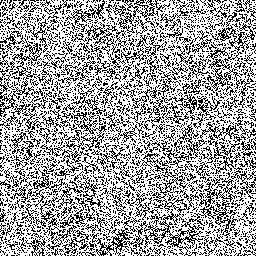

In [37]:
z = tf.random.normal((1, z_dim))  
logits = model_encryption.decoder(z)
x_hat = tf.sigmoid(logits)
x_hat = tf.reshape(x_hat, [-1, 256, 256]).numpy() *255.
x_hat = x_hat.astype(np.uint8)
data = np.reshape(x_hat,(256,256))
new_im = Image.fromarray(data)
new_im

In [38]:
model_decryption = VAE()
model_decryption.build(input_shape=(1, 65536))
optimizer = tf.optimizers.Adam(lr)

恢复正确的生成模型权重

In [39]:
b_decrypt=model_2.weights[9]/b
w_decrypt=model_2.weights[8]/w

In [40]:
model_decryption.weights[8].assign(w_decrypt)
model_decryption.weights[9].assign(b_decrypt)

<tf.Variable 'UnreadVariable' shape=(65536,) dtype=float32, numpy=
array([ 0.524742  ,  0.5020219 ,  0.4700898 , ..., -0.36593068,
       -0.32876965, -0.32486314], dtype=float32)>

使用具备正确权重参数的生成模型来生成图像，以达到解密的作用

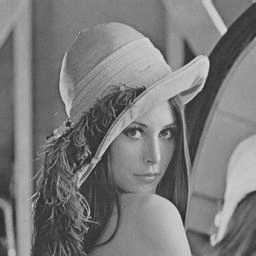

In [41]:
z = tf.random.normal((1, z_dim))  
logits = model_decryption.decoder(z)
x_hat = tf.sigmoid(logits)
x_hat = tf.reshape(x_hat, [-1, 256, 256]).numpy() *255.
x_hat = x_hat.astype(np.uint8)
data = np.reshape(x_hat,(256,256))
new_im = Image.fromarray(data)
new_im